# A Jupyter Notebook to Perform Pricing Using the Bates Formula
This notebook demonstrates the implementation of the Bates formula for pricing Bonus Certificates. It includes steps for importing libraries, defining the formula, setting parameters, simulating asset price paths, calculating option prices, and visualizing results.

## Import Required Libraries
Import necessary libraries such as NumPy, SciPy, and Matplotlib for numerical computations and visualizations.

In [1]:
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))  # Adds the parent directory to the Python path

In [2]:
# data
S0 = 81.25
B = 85
L = 65
H = 65
q = 0.02
start_date = valuation_date = datetime.datetime(2025, 4, 25)
maturity_date = datetime.datetime(2026, 3, 20)
#T = 328/365 # 08/04/25 - 16/06/26
T = (maturity_date - valuation_date).days / 365.0
print(T)

0.9013698630136986


In [3]:
# Import Required Libraries
from src.payout.payout import calculate_bonus_certificate_payout, plot_payout

In [4]:
plot_payout(B, H, S0)

## Calculate interest rate
Obtain interest rate from forward prices of the vanilla market prices

In [5]:
from src.interest_rates.calculate_interest_rates import calculate_interest_rate_from_parity, plot_interest_rates
import pandas as pd

In [6]:
# Load the CSV file into a pandas DataFrame
file_path = "../data/marketDataClose25-04/060625.csv"  # Adjust the path if necessary
df = pd.read_csv(file_path)
df['Spot'] = S0
df = df[['Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Spot', 'Strike', 'IV_Put', 'IV_Call']]

# Display the first few rows of the DataFrame
print(df.head())

   Bid_Call  Ask_Call  Bid_Put  Ask_Put   Spot  Strike  IV_Put  IV_Call
0      34.3      38.3      0.0     1.40  81.25    45.0   0.662    0.662
1      29.4      33.4      0.0     1.40  81.25    50.0   0.662    0.662
2      24.4      28.4      0.0     1.55  81.25    55.0   0.659    0.659
3      19.5      23.5      0.0     2.25  81.25    60.0   0.646    0.646
4      14.6      18.6      0.0     1.55  81.25    65.0   0.599    0.599


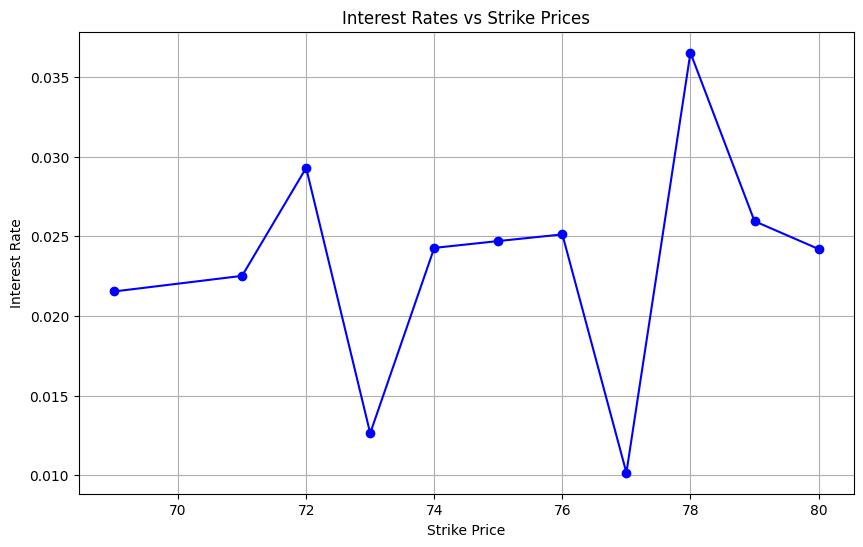

0.023357858029929766


In [7]:
# Calculate interest rates from parity
interest_rates = calculate_interest_rate_from_parity(df, q, T)
# print (interest_rates.head())

# Display the calculated interest rates
plot_interest_rates(interest_rates)

r = interest_rates['InterestRate'].mean()
print(r)
r = 0.04

In [8]:
# Store the mean interest rate in a variable
mean_interest_rate = interest_rates['InterestRate'].mean()
print(f'Mean Interest Rate: {mean_interest_rate}')

Mean Interest Rate: 0.023357858029929766


## Calculate volatility skew
Plot IV versus strike, note call are underpriced due to dividends and market crash after "liberation" day

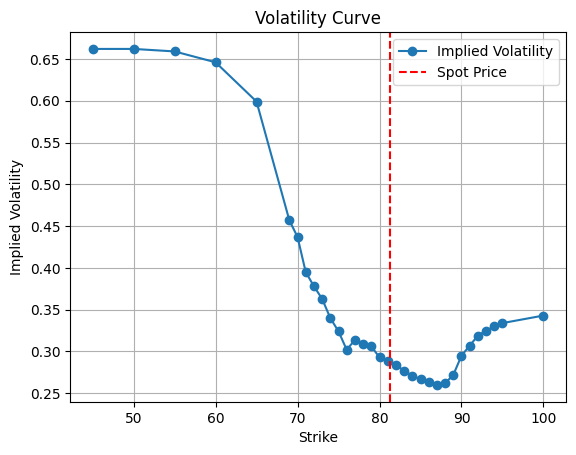

In [9]:
import matplotlib.pyplot as plt

# Add a new column for implied volatility based on the condition
df['ImpliedVolatility'] = df.apply(
    lambda row: row['IV_Put'] if row['Strike'] < S0 else row['IV_Call'], axis=1
)

# Plot the implied volatility curve
plt.plot(df['Strike'], df['ImpliedVolatility'], 'o-', label='Implied Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Curve")
plt.axvline(x=S0, color='red', linestyle='--', label='Spot Price')
plt.grid(True)
plt.legend()
plt.show()

## Calibrate Bates Model
Use the Bates model to calibrate on market prices and minimize the sum of squared errors.

In [10]:
from src.bates_formula.calibration import calibrate_bates_model

data_folder = '../data/marketDataClose25-04'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df['Source'] = file  # Add a column to identify the source file
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

# Filter out strikes between 70 and 100
combined_data = combined_data[(combined_data['Strike'] < 70) | (combined_data['Strike'] > 100)]

# Add a new column 'Mid_Price' based on the condition
combined_data['Mid_Price'] = combined_data.apply(
    lambda row: (row['Bid_Call'] + row['Ask_Call']) / 2 if row['Strike'] > S0 else (row['Bid_Put'] + row['Ask_Put']) / 2,
    axis=1
)

# Display the first few rows to verify the new column
print(combined_data[['Strike', 'Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Mid_Price']].head())
# Extract market prices and strikes
market_prices = combined_data['Mid_Price']  # Mid prices for calls
strikes = combined_data['Strike']

# Use the mean interest rate in Bates model calibration
calibrated_params = calibrate_bates_model(market_prices, strikes, S0, T, mean_interest_rate, q)
print("Calibrated Bates Model Parameters:", calibrated_params)

   Strike  Bid_Call  Ask_Call  Bid_Put  Ask_Put  Mid_Price
0    30.0      49.4      54.0     0.10     2.25      1.175
1    35.0      44.5      48.4     0.00     1.45      0.725
2    37.5      42.1      46.0     0.00     1.50      0.750
3    40.0      39.7      43.6     0.10     0.50      0.300
4    42.5      37.2      41.4     0.15     1.20      0.675
Calibrated Bates Model Parameters: {'V0': np.float64(0.01), 'kappa': np.float64(1.135255400816391), 'eta': np.float64(0.01), 'theta': np.float64(0.4527733796286657), 'rho': np.float64(0.99), 'jump_intensity': np.float64(1.0), 'jump_mean': np.float64(-0.5), 'jump_stddev': np.float64(0.01)}


## Plot Market Prices
Visualize the calibrated Bates model prices against the actual market prices.

    BS_Call  Last_Call  Bid_Call  Ask_Call  Change_Call  Delta_Call  IV_Call  \
16       BS      13.91     13.00     13.40         0.00       0.726    0.287   
17       BS      11.95     11.20     12.00         0.00       0.687    0.280   
18       BS      11.80      9.40     10.50         0.00       0.643    0.274   
19       BS      10.00      8.00      8.80         0.00       0.593    0.265   
20       BS       8.11      6.90      7.20         0.00       0.539    0.256   
21       BS       7.60      5.60      6.10         0.00       0.480    0.249   
22       BS       6.30      4.60      4.90         0.00       0.419    0.244   
23       BS       4.00      3.60      4.10        -0.95       0.359    0.238   
24       BS       3.20      2.80      3.10         0.00       0.300    0.231   
25       BS       2.55      2.10      2.40         0.00       0.247    0.224   
41       BS      17.30     13.20     14.80         0.00       0.723    0.286   
42       BS      12.00     10.90     13.

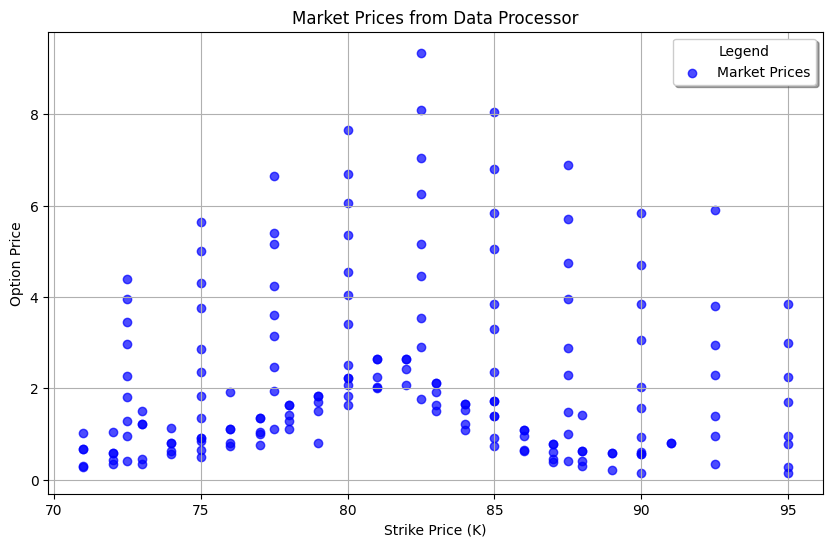

In [11]:
# Use MarketDataProcessor to load and process data
from src.data_processing.market_data_processor import MarketDataProcessor

# Initialize the MarketDataProcessor
data_folder = '../data/marketDataClose25-04'
S0 = 81.25
processor = MarketDataProcessor(data_folder, S0)
processor.load_and_process_data()

# Access the combined data
combined_data = processor.combined_data
# Drop rows where Bid_Call or Bid_Put is 0
combined_data = combined_data[(combined_data['Bid_Call'] > 0) & (combined_data['Bid_Put'] > 0)]
combined_data = combined_data[(combined_data['Strike'] > 70) & (combined_data['Strike'] < 100)]

print(combined_data.head(50))

# Plot market prices
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Strike'], combined_data['Mid_Price'], label='Market Prices', color='blue', marker='o', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Market Prices from Data Processor')
plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()

## Calibrate Bates Model Globally
Use the BatesModelGlobalCalibrator class to find the best parameters for all maturities combined.

In [12]:
import numpy as np

global_params = {
    'V0': np.float64(0.03314133662402323),
    'kappa': np.float64(2.0),
    'eta': np.float64(0.06797967406717075),
    'theta': np.float64(0.14987718209558357),
    'rho': np.float64(-0.99),
    'jump_intensity': np.float64(0.01),
    'jump_mean': np.float64(0.01),
    'jump_stddev': np.float64(0.01)
}

In [13]:
print(global_params)

{'V0': np.float64(0.03314133662402323), 'kappa': np.float64(2.0), 'eta': np.float64(0.06797967406717075), 'theta': np.float64(0.14987718209558357), 'rho': np.float64(-0.99), 'jump_intensity': np.float64(0.01), 'jump_mean': np.float64(0.01), 'jump_stddev': np.float64(0.01)}


In [14]:
from src.bates_formula.calibration_global import BatesModelGlobalCalibrator
from src.bates_formula.bates_model import BatesModel



# Perform global calibration for each maturity
calibrated_results = []

global_calibrator = BatesModelGlobalCalibrator( S0, r, q, start_date, combined_data)

# Perform global calibration across all maturities and strikes
#global_calibrator.calibrate_global_model(combined_data)

# Retrieve calibrated parameters
calibrated_params = global_calibrator.get_global_calibrated_params()

print("Global Calibrated Parameters:")
print(calibrated_params)


Global Calibrated Parameters:
{}


In [15]:
# Define a flag to control whether to use calibrated parameters or not
use_calibrated_params = False  # Set to False if you don't want to calibrate

# Perform calibration or use predefined parameters based on the flag
if use_calibrated_params:
    # Perform calibration
    calibrated_params = global_calibrator.get_global_calibrated_params()
    print("Global Calibrated Parameters:")
    print(calibrated_params)
else:
    # Use predefined parameters
    calibrated_params.update({
        'V0': 0.0281,
        'kappa': 3.0,
        'eta': 0.0703,
        'theta': 0.24,
        'rho': -0.99,
        'jump_intensity': 0.01,
        'jump_mean': 0.01,
        'jump_stddev': 0.01
    })
    print("Using predefined parameters:")
    print(calibrated_params)

Using predefined parameters:
{'V0': 0.0281, 'kappa': 3.0, 'eta': 0.0703, 'theta': 0.24, 'rho': -0.99, 'jump_intensity': 0.01, 'jump_mean': 0.01, 'jump_stddev': 0.01}


In [16]:
calibrated_model = BatesModel(
    S0=S0,
    r=r,
    q=q,
    T=T,
    strikes=strikes,
    V0=calibrated_params['V0'],
    kappa=calibrated_params['kappa'],
    eta=calibrated_params['eta'],
    theta=calibrated_params['theta'],
    rho=calibrated_params['rho'],
    jump_intensity=calibrated_params['jump_intensity'],
    jump_mean=calibrated_params['jump_mean'],
    jump_stddev=calibrated_params['jump_stddev']
)

priced_data = calibrated_model.price_options_for_all_maturities(combined_data, start_date)

print(priced_data.shape,combined_data.shape)  # Returns a tuple (rows, columns)


(180, 23) (180, 21)


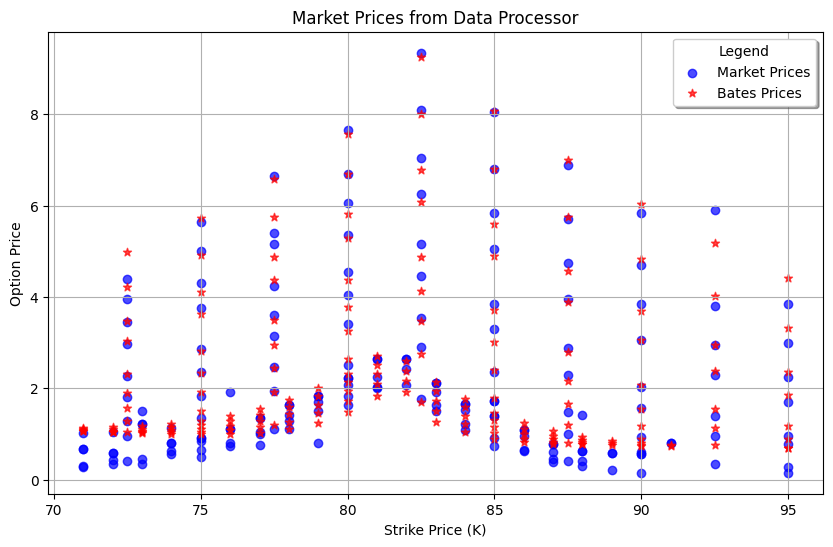

In [17]:
# Plot market prices
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Strike'], combined_data['Mid_Price'], label='Market Prices', color='blue', marker='o', alpha=0.7)
plt.scatter(priced_data['Strike'], priced_data['Bates_Price'], label='Bates Prices', color='red', marker='*', alpha=0.7)
# Add labels, title, and legend
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Market Prices from Data Processor')
plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()

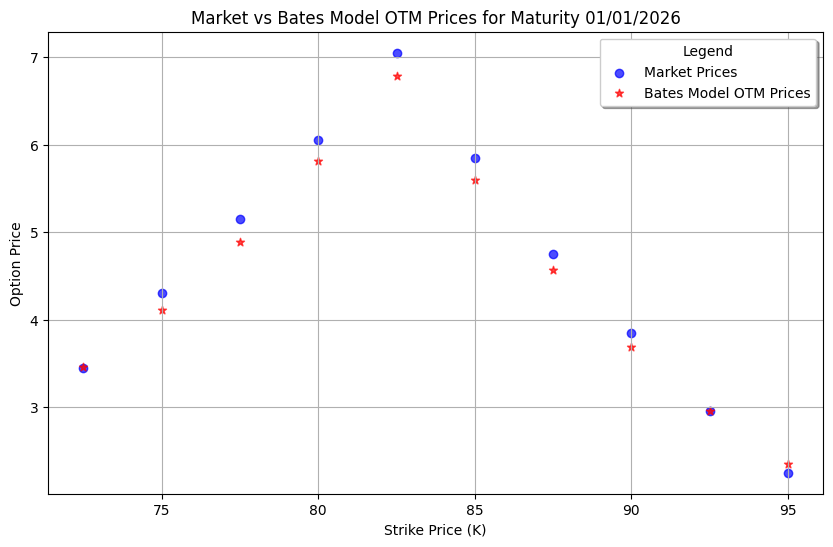

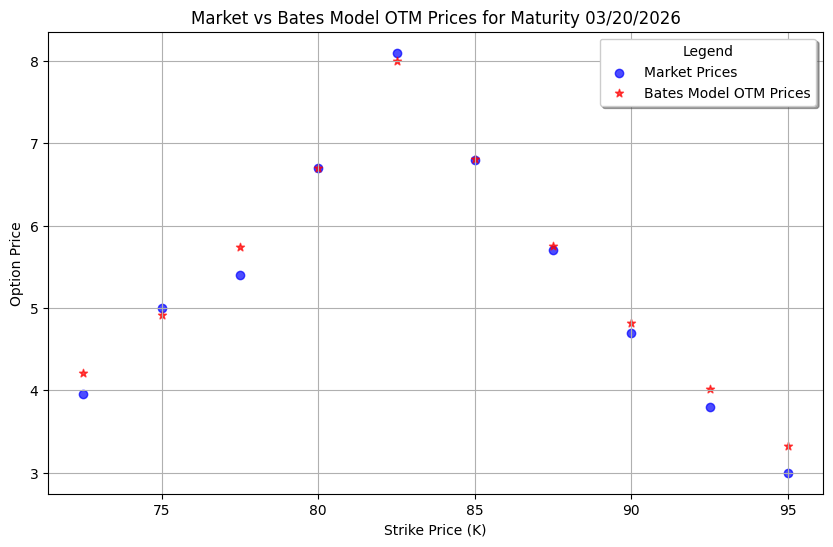

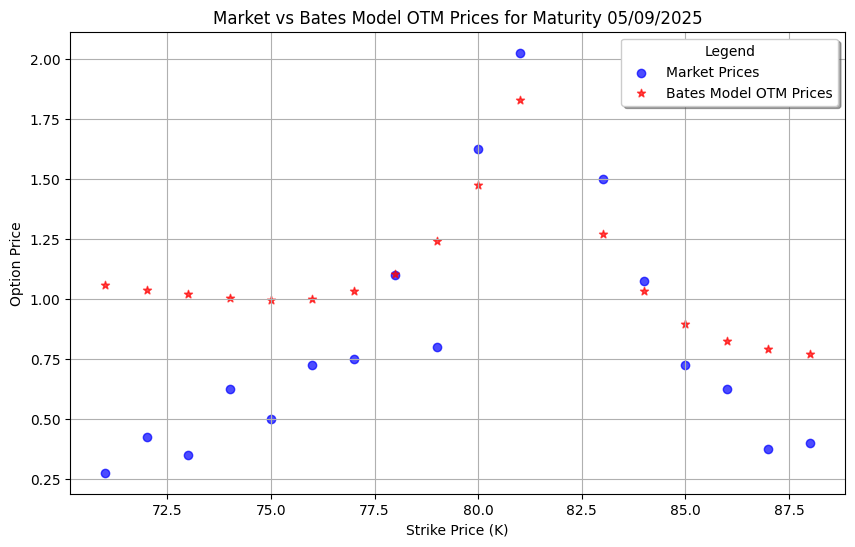

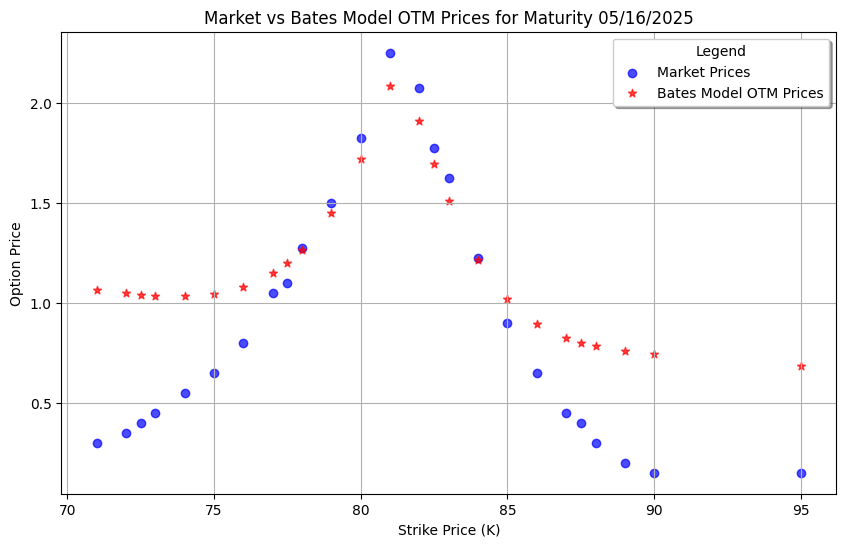

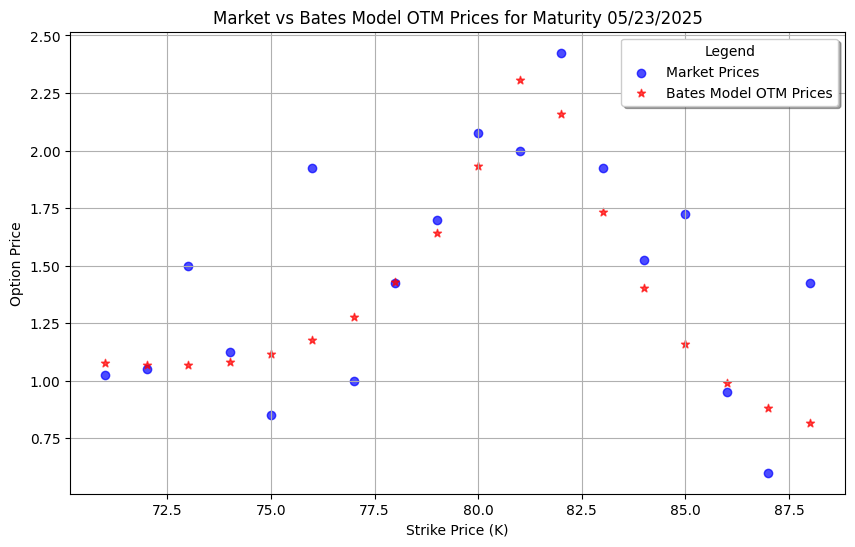

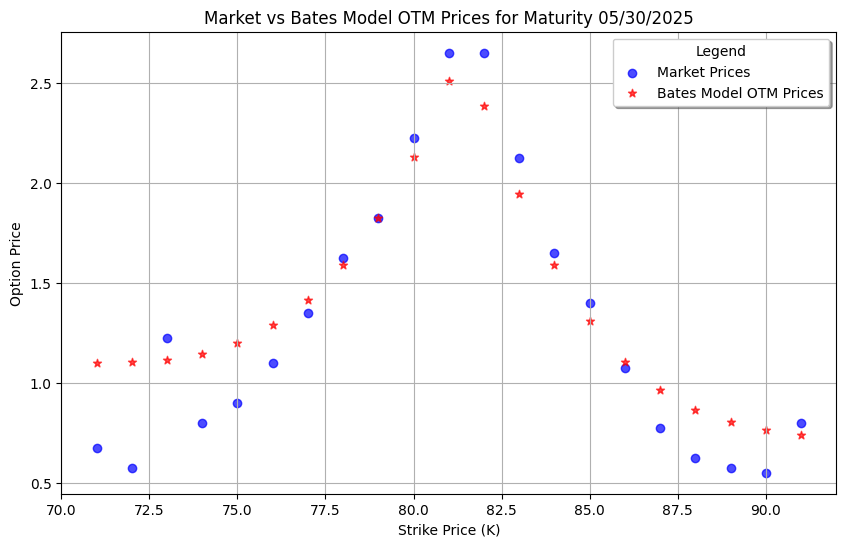

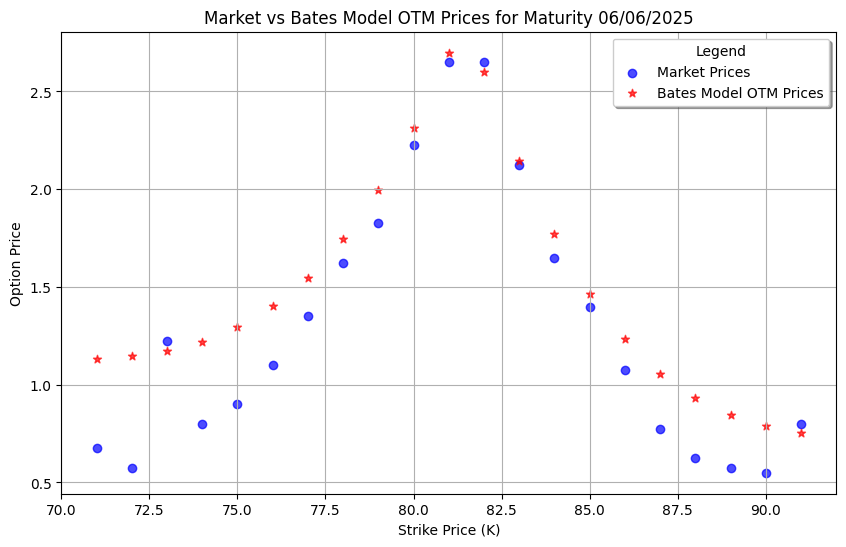

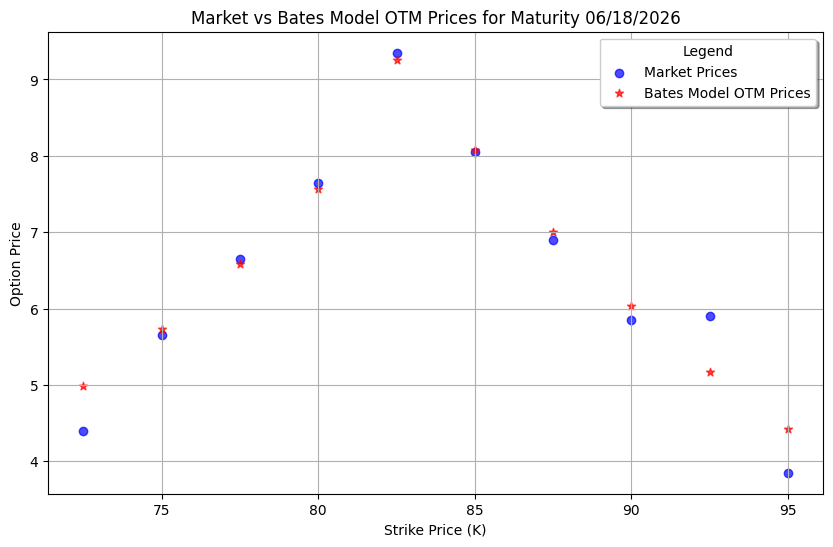

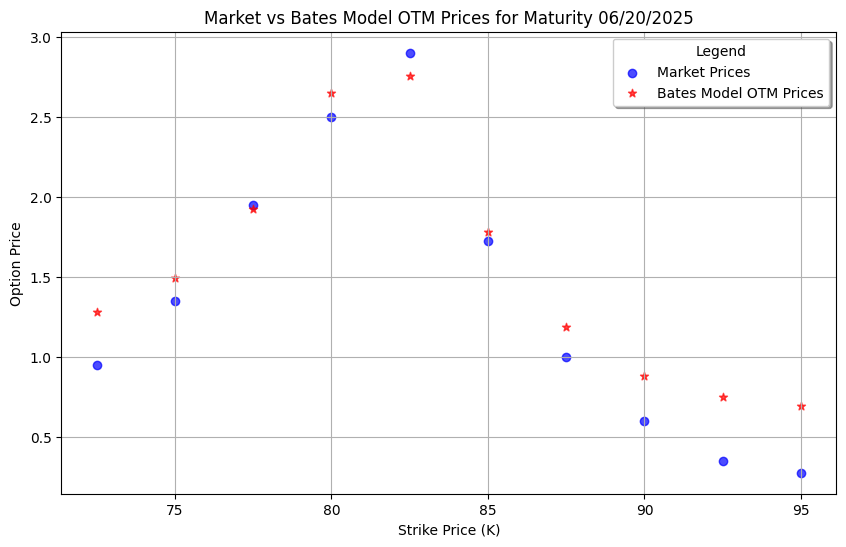

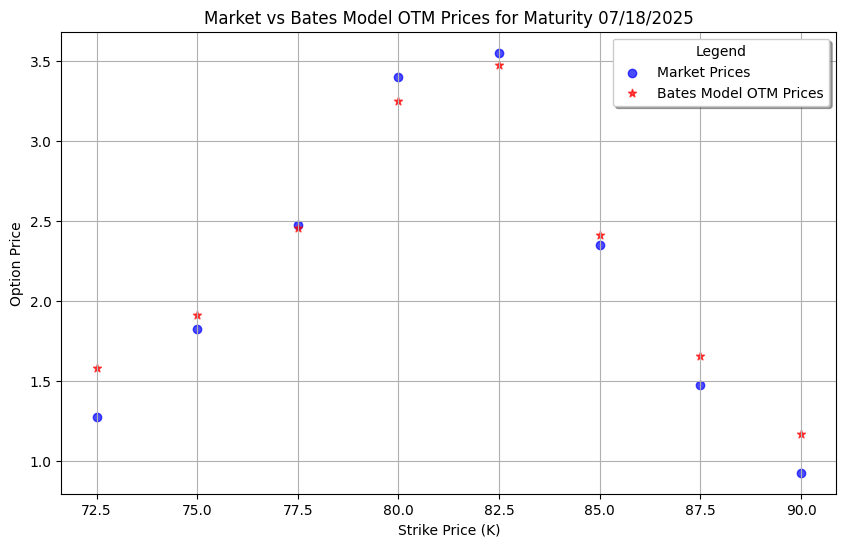

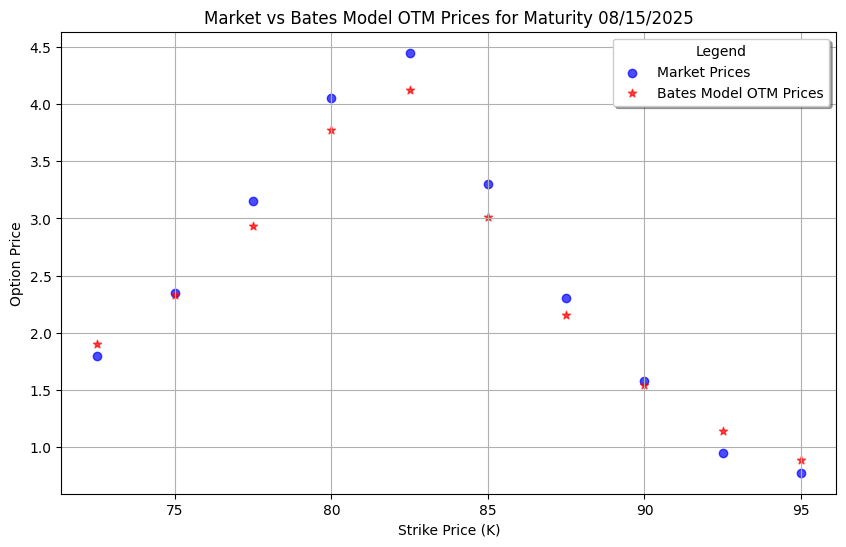

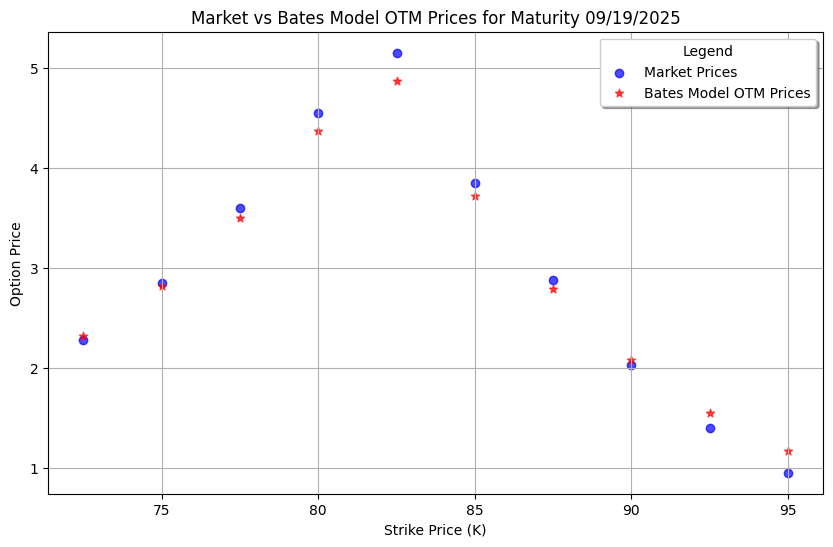

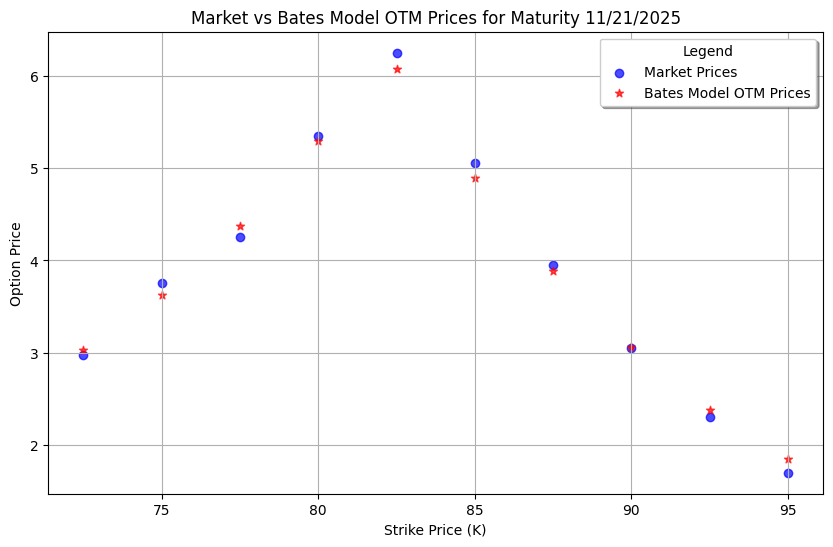

In [18]:
# Loop over each maturity separately
for maturity in combined_data['Maturity'].unique():
    # Filter data for this maturity
    df_maturity = combined_data[combined_data['Maturity'] == maturity]
    
    # Extract strikes and market mid-prices
    strikes = df_maturity['Strike'].values
    market_prices = df_maturity['Mid_Price'].values

    # Compute time to maturity T in years
    valuation_date = datetime.datetime(2025, 4, 25)
    maturity_date = datetime.datetime.strptime(maturity, "%m/%d/%Y")
    T = (maturity_date - valuation_date).days / 365

    # Initialize Bates model with calibrated parameters
    bates_model = BatesModel(
        S0, r, q, 
        calibrated_params['V0'], calibrated_params['kappa'], calibrated_params['eta'],
        calibrated_params['theta'], calibrated_params['rho'], 
        T,  # pass correct time to maturity
        strikes=strikes,
        jump_intensity=calibrated_params['jump_intensity'],
        jump_mean=calibrated_params['jump_mean'],
        jump_stddev=calibrated_params['jump_stddev']
    )

    # Separate strikes into OTM calls and puts
    otm_calls = strikes[strikes > S0]
    otm_puts = strikes[strikes < S0]

    # Calculate prices for OTM calls
    call_prices = []
    if len(otm_calls) > 0:
        bates_model.strikes = otm_calls
        call_prices = bates_model.price_options(rule='rectangular')

    # Calculate prices for OTM puts
    put_prices = []
    if len(otm_puts) > 0:
        bates_model.strikes = otm_puts
        put_prices = bates_model.price_put_options(rule='rectangular')

    # Combine OTM call and put prices into a single array for plotting
    otm_prices = [None] * len(strikes)
    for i, strike in enumerate(strikes):
        if strike in otm_calls:
            otm_prices[i] = call_prices[list(otm_calls).index(strike)]
        elif strike in otm_puts:
            otm_prices[i] = put_prices[list(otm_puts).index(strike)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(strikes, market_prices, label='Market Prices', color='blue', marker='o', alpha=0.7)
    plt.scatter(strikes, otm_prices, label='Bates Model OTM Prices', color='red', marker='*', alpha=0.7)

    plt.xlabel('Strike Price (K)')
    plt.ylabel('Option Price')
    plt.title(f'Market vs Bates Model OTM Prices for Maturity {maturity}')
    plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()


## Simulate Stock Paths and Price Down-and-Out Put Option
Use the Bates model to simulate stock price paths and calculate the price of a down-and-out put option.

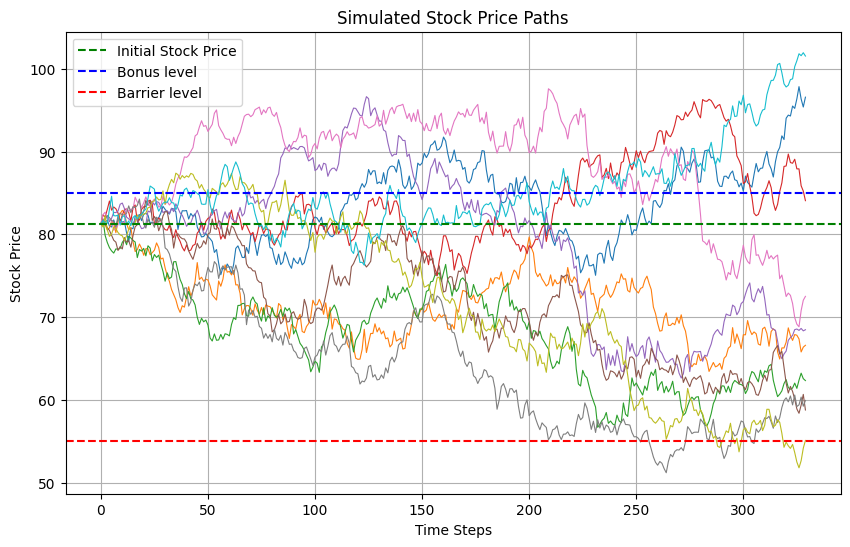

In [30]:
# Simulate stock price paths using the Bates model
n_paths = 100000  # Number of Monte Carlo paths
#n_steps = 365 * int(T   # Number of time steps (daily steps for 1 year)
seed = 42         # Random seed for reproducibility

K = 85  # Strike price
H = 55  # Barrier level

simulated_paths = calibrated_model.simulate_paths(n_paths=n_paths, seed=seed)

# Plot a few simulated paths
plt.figure(figsize=(10, 6))
for i in range(10):  # Plot 10 sample paths
    plt.plot(simulated_paths[i], lw=0.8)
plt.title("Simulated Stock Price Paths")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.axhline(y=S0, color='green', linestyle='--', label='Initial Stock Price')
plt.axhline(y=K, color='blue', linestyle='--', label='Bonus level')
plt.axhline(y=H, color='red', linestyle='--', label='Barrier level')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate statistics for simulated paths
above_90 = np.mean(simulated_paths[:, -1] > 90) * 100
between_90_and_55 = np.mean((simulated_paths[:, -1] <= 90) & (simulated_paths[:, -1] > 55) & (np.min(simulated_paths, axis=1) > 55)) * 100
below_55 = 100 - above_90 - between_90_and_55

print(f"Percentage of paths ending above 90: {above_90:.2f}%")
print(f"Percentage of paths ending between 90 and 55 without breaching the barrier: {between_90_and_55:.2f}%")
print(f"Percentage of paths ending below 55 or breaching the barrier: {below_55:.2f}%")

In [31]:
# Price a down-and-out put option using Monte Carlo simulation

down_and_out_put_price = calibrated_model.price_down_and_out_put(K=K, H=H, n_paths=n_paths, seed=seed)
print(f"Down-and-Out Put Option Price: {down_and_out_put_price:.4f}")

Down-and-Out Put Option Price: 6.2924


In [32]:
# Calculate the average stock path value at maturity
average_stock_at_maturity = simulated_paths[:, -1].mean()
print(f"Average Stock Path Value at Maturity: {average_stock_at_maturity:.2f}")

Average Stock Path Value at Maturity: 73.53


## Simulate Daily Delta Hedging for Bonus Certificate
This section simulates a daily delta hedging strategy for a Bonus Certificate (BC) over its lifetime using the Bates model.

In [26]:

# Initialize parameters
N = 1_000_000  # Notional
S0 = 81.25  # Initial stock price
K = 85  # Strike price of the option (for the barrier)


trading_days = int(T * 365)  # Number of trading days in a year
trading_days = 329
print(trading_days, T)
dt = 1 / trading_days  # Time step
epsilon = 1e-4  # Finite difference step for delta calculation


329 0.5753424657534246


In [27]:
print(calibrated_model.get_params())

{'S0': 81.25, 'r': 0.04, 'q': 0.02, 'V0': 0.0281, 'kappa': 3.0, 'eta': 0.0703, 'theta': 0.24, 'rho': -0.99, 'T': 0.9013698630136986, 'alpha': 1.5, 'N': 4096, 'eta_cm': 0.25, 'b': 12.566370614359172, 'strikes': 0       30.0
1       35.0
2       37.5
3       40.0
4       42.5
       ...  
375    105.0
376    110.0
377    115.0
378    120.0
379    125.0
Name: Strike, Length: 140, dtype: float64, 'jump_intensity': 0.01, 'jump_mean': 0.01, 'jump_stddev': 0.01}


1.8087536326080602 1.8087098495629896 -0.2189152253528892 0.7810847746471108


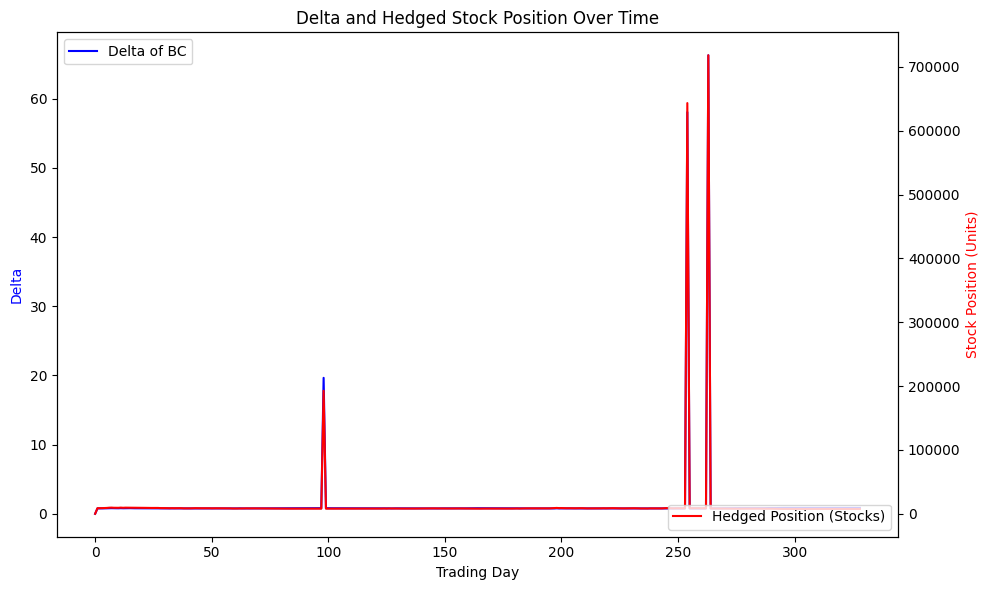

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate one Bates path
np.random.seed(42)
bates_path = calibrated_model.simulate_paths(n_paths=1, n_steps=trading_days, seed=42)[0]

# Initialize arrays to track delta and stock position
deltas = np.zeros(trading_days)
stock_position = np.zeros(trading_days)

# Initial stock price
S_t = S0
S_t = bates_path[0]  # Update the stock price at time t

# Calculate the delta of the down-and-out put at time t using finite difference
P_plus = calibrated_model.price_down_and_out_put(K, H, n_paths=1000, seed=42, S0=S_t + epsilon)
P_minus = calibrated_model.price_down_and_out_put(K, H, n_paths=1000, seed=42, S0=S_t - epsilon)
delta_DO = (P_plus - P_minus) / (2 * epsilon)
    
# Total delta of the Bonus Certificate
delta_BC = 1 + delta_DO
print(P_minus, P_plus, delta_DO, delta_BC)

# Loop over the trading days and calculate delta and hedge continuously
for t in range(1, trading_days):
    S_t = bates_path[t]  # Update the stock price at time t

    # Calculate the delta of the down-and-out put at time t using finite difference
    P_plus = calibrated_model.price_down_and_out_put(K, H, n_paths=1000, seed=42, S0=S_t + epsilon)
    P_minus = calibrated_model.price_down_and_out_put(K, H, n_paths=1000, seed=42, S0=S_t - epsilon)
    delta_DO = (P_plus - P_minus) / (2 * epsilon)
    
    # Total delta of the Bonus Certificate
    delta_BC = 1 + delta_DO

    # Track the delta and stock position
    deltas[t] = delta_BC
    stock_position[t] = delta_BC * N / (S_t+6.29)  # Adjust stock position


# Calculate the average stock price over the simulated path
average_stock_price = np.mean(bates_path)

# Calculate average hold time for stock
average_stock_position = np.mean(stock_position)
average_hold_time = average_stock_position * T / N
accrued_dividend = average_stock_position * q * T * average_stock_price
interest_cost = average_stock_position * r * T

# Plotting the results with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot delta on the first y-axis
ax1.plot(range(trading_days), deltas, label="Delta of BC", color="blue")
ax1.set_xlabel("Trading Day")
ax1.set_ylabel("Delta", color="blue")
ax1.tick_params(axis="y")
ax1.set_title("Delta and Hedged Stock Position Over Time")

# Create a second y-axis for the stock position
ax2 = ax1.twinx()
ax2.plot(range(trading_days), stock_position, label="Hedged Position (Stocks)", color="red")
ax2.set_ylabel("Stock Position (Units)", color="red")
ax2.tick_params(axis="y")


# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()
